In [63]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score
)
import numpy as np



In [64]:
predictions_path = "/Users/sagardhal/Desktop/Practice/personal-stock/results/predictions_20250908_092155.parquet"   # example


if predictions_path.endswith(".csv"):
    df = pd.read_csv(predictions_path)
elif predictions_path.endswith(".parquet"):
    df = pd.read_parquet(predictions_path)
else:
    raise ValueError("Unsupported file format for predictions")


print("Data loaded:", df.shape)
df.head()


Data loaded: (1372264, 642)


,Date,Open,High,Low,Close,adj_close,Volume,Ticker,year,month,...,pred14_rf_thresh_90,pred15_rf_auto_rate_1p,pred15_rf_auto_rate_3p,pred15_rf_auto_rate_5p,pred30_top3_daily,pred30_top5_daily,pred30_top10_daily,pred20_ens_ml50_and_momentum,pred21_ens_auto1p_or_top3,pred22_ens_manual2plus_and_auto3p
0,2000-01-03,0.936384,1.004464,0.907924,0.999442,0.840094,535796800.0,AAPL,2000,1,...,0,0,0,0,1,1,1,1,1,0
1,2000-01-04,0.966518,0.987723,0.903460,0.915179,0.769266,512377600.0,AAPL,2000,1,...,0,0,0,0,1,1,1,1,1,0
2,2000-01-05,0.926339,0.987165,0.919643,0.928571,0.780523,778321600.0,AAPL,2000,1,...,0,0,0,0,1,1,1,1,1,0
3,2000-01-06,0.947545,0.955357,0.848214,0.848214,0.712978,767972800.0,AAPL,2000,1,...,0,0,0,0,1,1,1,1,1,0
4,2000-01-07,0.861607,0.901786,0.852679,0.888393,0.746750,460734400.0,AAPL,2000,1,...,0,0,0,0,1,1,1,1,1,0


<Axes: >

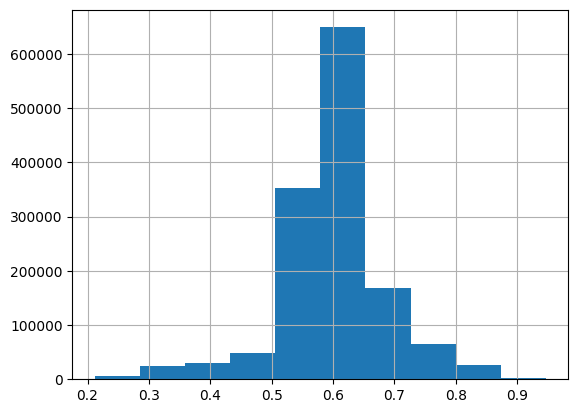

In [65]:
df.rf_prob_30d.hist()

In [66]:
TARGET_COL = "is_positive_growth_30d_future"
if TARGET_COL not in df.columns:
    raise KeyError(f"Target column '{TARGET_COL}' not found in df.columns")
y_true = df[TARGET_COL].astype(int)



In [67]:
# --- 4) Helpers ---
def precision_at_k(y_true: pd.Series, y_scores: pd.Series, k: int) -> float:
    """
    Precision@k: Of the top k highest-scored samples, how many are positive?
    - Handles k > n by clipping to n
    - Handles NaNs by treating them as lowest score
    - Keeps index alignment correct
    """
    n = len(y_scores)
    if n == 0:
        return np.nan
    k = min(k, n)
    # Replace NaNs with -inf so they go to the bottom
    scores = y_scores.fillna(float("-inf")).to_numpy()
    # Argpartition is O(n) and faster than full sort for small k
    if k == n:
        topk_idx = np.argsort(scores)[::-1][:k]
    else:
        # get indices of k largest (unordered), then sort them to get true top order
        part = np.argpartition(scores, -k)[-k:]
        topk_idx = part[np.argsort(scores[part])[::-1]]
    # y_true is a Series; iloc keeps positional alignment
    topk_true = y_true.iloc[topk_idx]
    return float(topk_true.mean())


def lift_at_k(prec_k: float, base_rate: float) -> float:
    """Lift@k = precision@k / base_rate (>= 0)."""
    if base_rate == 0:
        return np.nan
    return float(prec_k / base_rate)

In [68]:
df.columns.to_list()

['Date',
 'Open',
 'High',
 'Low',
 'Close',
 'adj_close',
 'Volume',
 'Ticker',
 'year',
 'month',
 'weekday',
 'wom',
 'month_wom',
 'growth_1d',
 'growth_3d',
 'growth_7d',
 'growth_30d',
 'growth_90d',
 'growth_252d',
 'growth_365d',
 'growth_future_30d',
 'is_positive_growth_30d_future',
 'sma10',
 'sma20',
 'growing_moving_average',
 'volatility',
 'sharpe',
 'high_minus_low_relative',
 'ln_volume',
 'ticker_type',
 'adx',
 'adxr',
 'apo',
 'aroon_up',
 'aroon_down',
 'aroonosc',
 'bop',
 'cci',
 'cmo',
 'dx',
 'macd',
 'macd_signal',
 'macd_hist',
 'macd_ext',
 'macd_signal_ext',
 'macd_hist_ext',
 'macd_fix',
 'macd_signal_fix',
 'macd_hist_fix',
 'mfi',
 'minus_di',
 'plus_di',
 'plus_dm',
 'mom',
 'ppo',
 'roc',
 'rocp',
 'rocr',
 'rocr100',
 'rsi',
 'stoch_slowk',
 'stoch_slowd',
 'stoch_fastk',
 'stoch_fastd',
 'stochrsi_fastk',
 'stochrsi_fastd',
 'trix',
 'ultosc',
 'willr',
 'ad',
 'adosc',
 'obv',
 'atr',
 'natr',
 'trange',
 'ht_dcperiod',
 'ht_dcphase',
 'ht_phasor_in

In [69]:
pred_cols = [col for col in df.columns if col.startswith('pred')]

results = []
k_values = [5, 10, 20, 50, 100, 200]
base_rate = y_true.mean()

for col in pred_cols:
    y_scores = df[col]
    # Robust binarization (0.5 threshold by default). If your model outputs logits,
    # apply sigmoid first or adjust threshold as needed.
    y_pred = (y_scores >= 0.5).astype(int)

    # Some metrics need non-NaN scores
    scores_no_nan = y_scores.fillna(y_scores.min() - 1e9)

    row = {
        "model": col,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_true, scores_no_nan),
        "pr_auc": average_precision_score(y_true, scores_no_nan),  # area under PR curve
        "base_rate_%": base_rate * 100,
    }

    # precision@k and lift@k
    for k in k_values:
        p_at_k = precision_at_k(y_true, y_scores, k)
        row[f"precision@{k}"] = p_at_k
        row[f"lift@{k}"] = lift_at_k(p_at_k, base_rate)

    results.append(row)

metrics_df = (
    pd.DataFrame(results)
      .sort_values(["roc_auc", "pr_auc"], ascending=False)
      .reset_index(drop=True)
)

# Pretty display: show precision@k and lift@k together
cols_order = (
    ["model", "roc_auc", "pr_auc", "accuracy", "precision", "recall", "f1", "base_rate_%"]
    + sum(([f"precision@{k}", f"lift@{k}"] for k in k_values), [])
)
display(metrics_df[cols_order])


,model,roc_auc,pr_auc,accuracy,precision,recall,f1,base_rate_%,precision@5,lift@5,precision@10,lift@10,precision@20,lift@20,precision@50,lift@50,precision@100,lift@100,precision@200,lift@200
0,pred12_rf_thresh_65,0.556940,0.614217,0.508138,0.715972,0.251812,0.372584,57.996931,1.0,1.724229,1.0,1.724229,1.00,1.724229,0.66,1.137991,0.66,1.137991,0.605,1.043159
1,pred11_rf_thresh_50,0.553436,0.607265,0.620276,0.608070,0.971350,0.747931,57.996931,0.8,1.379383,0.9,1.551806,0.95,1.638018,0.98,1.689745,0.83,1.431110,0.730,1.258687
2,pred20_ens_ml50_and_momentum,0.519616,0.589818,0.525607,0.597648,0.557075,0.576649,57.996931,0.0,0.000000,0.0,0.000000,0.15,0.258634,0.22,0.379330,0.61,1.051780,0.575,0.991432
3,pred5_manual_vix_contrarian,0.512351,0.586317,0.462271,0.611831,0.199233,0.300586,57.996931,1.0,1.724229,1.0,1.724229,0.75,1.293172,0.38,0.655207,0.54,0.931084,0.495,0.853493
4,pred3_manual_declining_rates,0.509746,0.584799,0.505618,0.589950,0.483939,0.531712,57.996931,0.2,0.344846,0.2,0.344846,0.30,0.517269,0.38,0.655207,0.52,0.896599,0.605,1.043159
5,pred30_top10_daily,0.509169,0.585168,0.436490,0.674923,0.054749,0.101282,57.996931,0.6,1.034538,0.6,1.034538,0.65,1.120749,0.54,0.931084,0.68,1.172476,0.700,1.206960
6,pred13_rf_thresh_80,0.508488,0.585515,0.431644,0.777793,0.028033,0.054116,57.996931,0.6,1.034538,0.5,0.862115,0.55,0.948326,0.78,1.344899,0.75,1.293172,0.700,1.206960
7,pred15_rf_auto_rate_5p,0.508443,0.585408,0.431780,0.766769,0.029114,0.056098,57.996931,1.0,1.724229,0.9,1.551806,0.80,1.379383,0.76,1.310414,0.81,1.396626,0.770,1.327656
8,pred30_top5_daily,0.505157,0.582944,0.428818,0.686772,0.027855,0.053539,57.996931,0.2,0.344846,0.1,0.172423,0.40,0.689692,0.50,0.862115,0.60,1.034538,0.670,1.155234
9,pred15_rf_auto_rate_3p,0.504930,0.583942,0.425847,0.959365,0.010472,0.020717,57.996931,1.0,1.724229,1.0,1.724229,1.00,1.724229,1.00,1.724229,0.98,1.689745,0.980,1.689745


In [70]:
print(df.info())
print(df.describe(include="all").transpose())

# Missing values
missing_summary = df.isnull().mean().sort_values(ascending=False)
print("Missing % per column:\n", missing_summary.head(20))

# Class balance
print("Target balance:", y_true.value_counts(normalize=True))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372264 entries, 0 to 1372263
Columns: 642 entries, Date to pred22_ens_manual2plus_and_auto3p
dtypes: datetime64[ns](1), float64(151), int32(459), int64(2), int8(21), object(8)
memory usage: 4.0+ GB
None


/Users/sagardhal/Desktop/Practice/personal-stock/.venv/lib/python3.13/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


                                       count unique  top freq  \
Date                                 1372264    NaN  NaN  NaN   
Open                               1372240.0    NaN  NaN  NaN   
High                               1372240.0    NaN  NaN  NaN   
Low                                1372240.0    NaN  NaN  NaN   
Close                              1372240.0    NaN  NaN  NaN   
...                                      ...    ...  ...  ...   
pred30_top5_daily                  1372264.0    NaN  NaN  NaN   
pred30_top10_daily                 1372264.0    NaN  NaN  NaN   
pred20_ens_ml50_and_momentum       1372264.0    NaN  NaN  NaN   
pred21_ens_auto1p_or_top3          1372264.0    NaN  NaN  NaN   
pred22_ens_manual2plus_and_auto3p  1372264.0    NaN  NaN  NaN   

                                                            mean  \
Date                               2013-09-27 18:11:17.845079552   
Open                                                   92.457022   
High           

In [71]:
binary_cols = [c for c in df.columns if c.startswith("pred") and c != "rf_prob_30d"]
prob_cols   = ["rf_prob_30d"]  # extend if you add more prob outputs


In [72]:
for col in binary_cols:
    y_pred = df[col].fillna(0).astype(int)
    print(
        col,
        "Acc:", accuracy_score(y_true, y_pred),
        "Prec:", precision_score(y_true, y_pred, zero_division=0),
        "Rec:", recall_score(y_true, y_pred, zero_division=0),
        "F1:", f1_score(y_true, y_pred, zero_division=0),
    )


pred0_manual_cci Acc: 0.4234374726728968 Prec: 0.5679367570552504 Rec: 0.024552974037249754 F1: 0.04707098104490303
pred1_manual_prev_g1 Acc: 0.5022196895058094 Prec: 0.5705909523910858 Rec: 0.5727360338547327 F1: 0.5716614808488437
pred2_manual_prev_g1_and_snp Acc: 0.42003069380235875 Prec: 0.0 Rec: 0.0 F1: 0.0
pred3_manual_declining_rates Acc: 0.5056184524260637 Prec: 0.5899500196827177 Rec: 0.483938980060839 F1: 0.5317119569719092
pred4_manual_fed_easing Acc: 0.4761022660362729 Prec: 0.5691435349514301 Rec: 0.39790368037031126 F1: 0.4683624617869297
pred5_manual_vix_contrarian Acc: 0.462271108183265 Prec: 0.6118311641708114 Rec: 0.1992332928326324 F1: 0.3005855735454971
pred6_manual_stock_btc_momentum Acc: 0.4210428897063539 Prec: 0.7651775486827033 Rec: 0.002517996006890564 F1: 0.005019474257661336
pred10_rf_thresh_21 Acc: 0.5799693061976413 Prec: 0.5799693061976413 Rec: 1.0 F1: 0.7341526242600207
pred11_rf_thresh_50 Acc: 0.6202764191146893 Prec: 0.6080703316479831 Rec: 0.971349628

In [73]:
for k in [5, 10, 20, 50]:
    p_at_k = precision_at_k(y_true, df["rf_prob_30d"], k)
    print(f"rf_prob_30d | Precision@{k}: {p_at_k:.3f}, Lift@{k}: {lift_at_k(p_at_k, base_rate):.2f}")


rf_prob_30d | Precision@5: 1.000, Lift@5: 1.72
rf_prob_30d | Precision@10: 1.000, Lift@10: 1.72
rf_prob_30d | Precision@20: 1.000, Lift@20: 1.72
rf_prob_30d | Precision@50: 1.000, Lift@50: 1.72


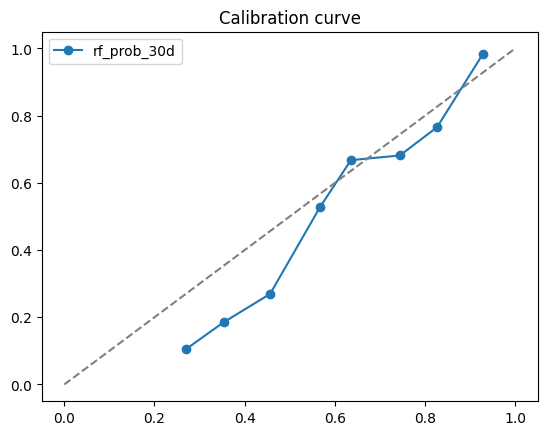

In [74]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_true, df["rf_prob_30d"], n_bins=10)
plt.plot(prob_pred, prob_true, marker="o", label="rf_prob_30d")
plt.plot([0,1],[0,1],"--", color="gray")
plt.legend(); plt.title("Calibration curve"); plt.show()


In [75]:
def simulate_threshold(y_true, y_scores, threshold=0.6):
    picks = (y_scores >= threshold).astype(int)
    return precision_score(y_true, picks), recall_score(y_true, picks)

for t in [0.4, 0.5, 0.6, 0.7]:
    prec, rec = simulate_threshold(y_true, df["rf_prob_30d"], t)
    print(f"rf_prob_30d τ={t}: Precision={prec:.3f}, Recall={rec:.3f}")


rf_prob_30d τ=0.4: Precision=0.594, Recall=0.991
rf_prob_30d τ=0.5: Precision=0.608, Recall=0.971
rf_prob_30d τ=0.6: Precision=0.674, Recall=0.592
rf_prob_30d τ=0.7: Precision=0.703, Recall=0.113


In [76]:
def simulate_binary_strategy(df, pred_col, return_col="growth_future_30d"):
    picks = df[df[pred_col] == 1]
    if picks.empty:
        return np.nan
    return {
        "avg_return": picks[return_col].mean(),
        "win_rate": (picks[return_col] > 0).mean(),
        "sharpe": picks[return_col].mean() / (picks[return_col].std() + 1e-9),
        "n_trades": len(picks),
    }

for col in binary_cols:
    print(col, simulate_binary_strategy(df, col))


pred0_manual_cci {'avg_return': np.float64(1.0156354621964798), 'win_rate': np.float64(1.0), 'sharpe': np.float64(8.280734184029704), 'n_trades': 34407}
pred1_manual_prev_g1 {'avg_return': np.float64(1.0156212260074475), 'win_rate': np.float64(1.0), 'sharpe': np.float64(8.657842801240522), 'n_trades': 798863}
pred2_manual_prev_g1_and_snp nan
pred3_manual_declining_rates {'avg_return': np.float64(1.022848588984539), 'win_rate': np.float64(1.0), 'sharpe': np.float64(7.219960772969457), 'n_trades': 652857}
pred4_manual_fed_easing {'avg_return': np.float64(1.018449702660138), 'win_rate': np.float64(1.0), 'sharpe': np.float64(6.796588317620806), 'n_trades': 556415}
pred5_manual_vix_contrarian {'avg_return': np.float64(1.027895282099551), 'win_rate': np.float64(1.0), 'sharpe': np.float64(7.238214457287888), 'n_trades': 259163}
pred6_manual_stock_btc_momentum {'avg_return': np.float64(1.056260609649023), 'win_rate': np.float64(1.0), 'sharpe': np.float64(12.84599857038672), 'n_trades': 2619}
p

In [77]:
def simulate_prob_threshold(df, prob_col="rf_prob_30d", return_col="growth_future_30d", tau=0.6):
    picks = df[df[prob_col] >= tau]
    if picks.empty:
        return np.nan
    return {
        "avg_return": picks[return_col].mean(),
        "win_rate": (picks[return_col] > 0).mean(),
        "sharpe": picks[return_col].mean() / (picks[return_col].std() + 1e-9),
        "n_trades": len(picks),
    }

for t in [0.4, 0.5, 0.6, 0.7,0.8,0.9,0.95]:
    print(f"τ={t}", simulate_prob_threshold(df, tau=t))


τ=0.4 {'avg_return': np.float64(1.023577983392457), 'win_rate': np.float64(1.0), 'sharpe': np.float64(8.045660680563602), 'n_trades': 1328426}
τ=0.5 {'avg_return': np.float64(1.0270957398284992), 'win_rate': np.float64(1.0), 'sharpe': np.float64(8.096891938063054), 'n_trades': 1271348}
τ=0.6 {'avg_return': np.float64(1.0412774057425824), 'win_rate': np.float64(1.0), 'sharpe': np.float64(7.9035795803913915), 'n_trades': 699390}
τ=0.7 {'avg_return': np.float64(1.0640688899801445), 'win_rate': np.float64(1.0), 'sharpe': np.float64(5.580350770673184), 'n_trades': 128181}
τ=0.8 {'avg_return': np.float64(1.104642966351848), 'win_rate': np.float64(1.0), 'sharpe': np.float64(6.064256491571287), 'n_trades': 28685}
τ=0.9 {'avg_return': np.float64(1.2690783040303806), 'win_rate': np.float64(1.0), 'sharpe': np.float64(7.082317612563434), 'n_trades': 1582}
τ=0.95 nan


In [78]:
def simulate_topk(df, prob_col="rf_prob_30d", return_col="growth_future_30d", k=20):
    ranked = df.sort_values(prob_col, ascending=False).head(k)
    return {
        "avg_return": ranked[return_col].mean(),
        "win_rate": (ranked[return_col] > 0).mean(),
        "sharpe": ranked[return_col].mean() / (ranked[return_col].std() + 1e-9),
        "n_trades": len(ranked),
    }

for k in [5, 10, 20, 50,100,200,250]:
    print(f"Top-{k}", simulate_topk(df, k=k))


Top-5 {'avg_return': np.float64(1.3859317010227108), 'win_rate': np.float64(1.0), 'sharpe': np.float64(8.892216123136203), 'n_trades': 5}
Top-10 {'avg_return': np.float64(1.3590716560620693), 'win_rate': np.float64(1.0), 'sharpe': np.float64(10.986172343696838), 'n_trades': 10}
Top-20 {'avg_return': np.float64(1.3496580405625804), 'win_rate': np.float64(1.0), 'sharpe': np.float64(10.26409626611731), 'n_trades': 20}
Top-50 {'avg_return': np.float64(1.3444489803007178), 'win_rate': np.float64(1.0), 'sharpe': np.float64(9.758318569939327), 'n_trades': 50}
Top-100 {'avg_return': np.float64(1.3224664925199932), 'win_rate': np.float64(1.0), 'sharpe': np.float64(9.40711795700165), 'n_trades': 100}
Top-200 {'avg_return': np.float64(1.3175627802740462), 'win_rate': np.float64(1.0), 'sharpe': np.float64(9.549090760494265), 'n_trades': 200}
Top-250 {'avg_return': np.float64(1.313056205095614), 'win_rate': np.float64(1.0), 'sharpe': np.float64(9.630313002683435), 'n_trades': 250}


In [ ]:
import numpy as np
import pandas as pd
from typing import List, Optional, Dict, Tuple

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score
)

def analyze_predictions(
    df: pd.DataFrame,
    target_col: str = "is_positive_growth_30d_future",
    return_col: str = "growth_future_30d",
    prob_cols: Optional[List[str]] = None,   # e.g. ["rf_prob_30d"]
    binary_cols: Optional[List[str]] = None, # e.g. [c for c in df if c.startswith("pred_")]
    k_values: List[int] = [5, 10, 20, 50, 100, 200],
    thresholds: List[float] = [0.4, 0.5, 0.6, 0.7,0.8,0.9,0.95],
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Unified EDA + Simulation for predictions (without calibration).

    Returns:
        metrics_df: rows per (strategy, variant) with classification metrics & precision@k/lift@k.
        simulations_df: rows per (strategy, variant) with investment metrics: avg_return, win_rate, sharpe, n_trades.
    """
    # ---------- helpers ----------
    def precision_at_k(y_true: pd.Series, y_scores: pd.Series, k: int) -> float:
        n = len(y_scores)
        if n == 0:
            return np.nan
        k = min(k, n)
        scores = y_scores.fillna(float("-inf")).to_numpy()
        if k == n:
            topk_idx = np.argsort(scores)[::-1][:k]
        else:
            part = np.argpartition(scores, -k)[-k:]
            topk_idx = part[np.argsort(scores[part])[::-1]]
        return float(y_true.iloc[topk_idx].mean())

    def lift_at_k(prec_k: float, base_rate: float) -> float:
        if base_rate == 0 or pd.isna(prec_k):
            return np.nan
        return float(prec_k / base_rate)

    def sharpe_ratio(returns: pd.Series, rf: float = 0.0) -> float:
        returns = pd.to_numeric(returns, errors="coerce").dropna()
        if returns.empty:
            return np.nan
        excess = returns - rf
        std = excess.std(ddof=1)
        return float(excess.mean() / (std + 1e-12))

    def _safe_auc(y_true, scores):
        s = pd.to_numeric(scores, errors="coerce")
        if s.nunique(dropna=True) <= 1:
            return np.nan, np.nan
        s = s.fillna(s.min() - 1e9)
        return float(roc_auc_score(y_true, s)), float(average_precision_score(y_true, s))

    # ---------- inputs & guards ----------
    assert target_col in df.columns, f"Missing target_col: {target_col}"
    assert return_col in df.columns, f"Missing return_col: {return_col}"

    if prob_cols is None:
        prob_cols = [c for c in df.columns if c.endswith("_prob_30d") or c.startswith("rf_prob")]
    if binary_cols is None:
        binary_cols = [c for c in df.columns if c.startswith("pred") and c not in prob_cols]

    y_true = df[target_col].astype(int)
    base_rate = float(y_true.mean())

    # ---------- build outputs ----------
    metrics_rows: List[Dict] = []
    sim_rows: List[Dict] = []

    # ===== 1) Binary strategies (0/1) =====
    for col in binary_cols:
        y_pred = pd.to_numeric(df[col], errors="coerce").fillna(0).astype(int)

        row = {
            "strategy": col,
            "type": "binary",
            "base_rate": base_rate,
            "accuracy": accuracy_score(y_true, y_pred),
            "precision": precision_score(y_true, y_pred, zero_division=0),
            "recall": recall_score(y_true, y_pred, zero_division=0),
            "f1": f1_score(y_true, y_pred, zero_division=0),
            "roc_auc": np.nan,
            "pr_auc": np.nan,
        }
        for k in k_values:
            p_at_k = precision_at_k(y_true, y_pred, k)
            row[f"precision@{k}"] = p_at_k
            row[f"lift@{k}"] = lift_at_k(p_at_k, base_rate)
        metrics_rows.append(row)
        
        std_ret = float(picks.std(ddof=1)) if len(picks) > 1 else np.nan
        efficiency = float(picks.mean() * len(picks)) if not picks.empty else np.nan
        ra_efficiency = (efficiency / (std_ret + 1e-12)) if std_ret == std_ret else np.nan  # NaN-safe


        # simulation: buy where label==1
        picks = df.loc[y_pred == 1, return_col]
        sim_rows.append({
            "strategy": col,
            "variant": "binary@0.5",
            "type": "binary",
            "n_trades": int(picks.notna().sum()),
            "avg_return": float(picks.mean()) if not picks.empty else np.nan,
            "win_rate": float((picks > 0).mean()) if not picks.empty else np.nan,
            "sharpe": sharpe_ratio(picks)
        })

    # ===== 2) Probabilistic strategies =====
    for col in prob_cols:
        scores = pd.to_numeric(df[col], errors="coerce")

        y_pred = (scores.fillna(0) >= 0.5).astype(int)
        roc_auc, pr_auc = _safe_auc(y_true, scores)
        row = {
            "strategy": col,
            "variant": "prob_raw",
            "type": "prob",
            "base_rate": base_rate,
            "accuracy": accuracy_score(y_true, y_pred),
            "precision": precision_score(y_true, y_pred, zero_division=0),
            "recall": recall_score(y_true, y_pred, zero_division=0),
            "f1": f1_score(y_true, y_pred, zero_division=0),
            "roc_auc": roc_auc,
            "pr_auc": pr_auc,
        }
        for k in k_values:
            p_at_k = precision_at_k(y_true, scores, k)
            row[f"precision@{k}"] = p_at_k
            row[f"lift@{k}"] = lift_at_k(p_at_k, base_rate)
        metrics_rows.append(row)

        # simulations: thresholds
        for t in thresholds:
            picks = df.loc[scores >= t, return_col]
            sim_rows.append({
                "strategy": col,
                "variant": f"τ={t:.2f}",
                "type": "prob",
                "n_trades": int(picks.notna().sum()),
                "avg_return": float(picks.mean()) if not picks.empty else np.nan,
                "win_rate": float((picks > 0).mean()) if not picks.empty else np.nan,
                "sharpe": sharpe_ratio(picks),
            })

        # simulations: top-k
        for k in k_values:
            ranked = df.loc[scores.sort_values(ascending=False).index][:k]
            picks = ranked[return_col]
            sim_rows.append({
                "strategy": col,
                "variant": f"top-{k}",
                "type": "prob",
                "n_trades": int(picks.notna().sum()),
                "avg_return": float(picks.mean()) if not picks.empty else np.nan,
                "win_rate": float((picks > 0).mean()) if not picks.empty else np.nan,
                "sharpe": sharpe_ratio(picks),
                "std_return": std_ret,            # <-- NEW
                "efficiency": efficiency,         # <-- NEW
            "ra_efficiency": ra_efficiency,   # <-- NEW
            })
        
        std_ret = float(picks.std(ddof=1)) if len(picks) > 1 else np.nan
        efficiency = float(picks.mean() * len(picks)) if not picks.empty else np.nan
        ra_efficiency = (efficiency / (std_ret + 1e-12)) if std_ret == std_ret else np.nan  # NaN-safe


    metrics_df = pd.DataFrame(metrics_rows).reset_index(drop=True)
    simulations_df = pd.DataFrame(sim_rows).reset_index(drop=True)

    return metrics_df, simulations_df


In [108]:
import numpy as np
import pandas as pd
from typing import List, Optional, Dict, Tuple
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score
)

def analyze_predictions(
    df: pd.DataFrame,
    target_col: str = "is_positive_growth_30d_future",
    return_col: str = "growth_future_30d",
    prob_cols: Optional[List[str]] = None,   # e.g. ["rf_prob_30d"]
    binary_cols: Optional[List[str]] = None, # e.g. [c for c in df if c.startswith("pred_")]
    k_values: List[int] = [5, 10, 20, 50, 100, 200],
    thresholds: List[float] = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95],
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Unified EDA + Simulation for predictions (without calibration).

    Returns:
        metrics_df: rows per (strategy, variant) with classification metrics & precision@k/lift@k.
        simulations_df: rows per (strategy, variant) with investment metrics: avg_return, win_rate, sharpe, n_trades,
                        plus std_return, efficiency, ra_efficiency.
    """
    # ---------- helpers ----------
    def precision_at_k(y_true: pd.Series, y_scores: pd.Series, k: int) -> float:
        n = len(y_scores)
        if n == 0: return np.nan
        k = min(k, n)
        scores = y_scores.fillna(float("-inf")).to_numpy()
        if k == n:
            topk_idx = np.argsort(scores)[::-1][:k]
        else:
            part = np.argpartition(scores, -k)[-k:]
            topk_idx = part[np.argsort(scores[part])[::-1]]
        return float(y_true.iloc[topk_idx].mean())

    def lift_at_k(prec_k: float, base_rate: float) -> float:
        if base_rate == 0 or pd.isna(prec_k): return np.nan
        return float(prec_k / base_rate)

    def sharpe_ratio(returns: pd.Series, rf: float = 0.0) -> float:
        r = pd.to_numeric(returns, errors="coerce").dropna()
        if r.empty: return np.nan
        excess = r - rf
        std = excess.std(ddof=1)
        return float(excess.mean() / (std + 1e-12))

    def _safe_auc(y_true, scores):
        s = pd.to_numeric(scores, errors="coerce")
        if s.nunique(dropna=True) <= 1:
            return np.nan, np.nan
        s = s.fillna(s.min() - 1e9)
        return float(roc_auc_score(y_true, s)), float(average_precision_score(y_true, s))

    # ---------- inputs & guards ----------
    assert target_col in df.columns, f"Missing target_col: {target_col}"
    assert return_col in df.columns, f"Missing return_col: {return_col}"

    if prob_cols is None:
        prob_cols = [c for c in df.columns if c.endswith("_prob_30d") or c.startswith("rf_prob")]
    if binary_cols is None:
        binary_cols = [c for c in df.columns if c.startswith("pred") and c not in prob_cols]

    y_true = df[target_col].astype(int)
    base_rate = float(y_true.mean())

    metrics_rows: List[Dict] = []
    sim_rows: List[Dict] = []

    # ===== 1) Binary strategies (0/1) =====
    for col in binary_cols:
        y_pred = pd.to_numeric(df[col], errors="coerce").fillna(0).astype(int)

        row = {
            "strategy": col,
            "variant": "binary@0.5",
            "type": "binary",
            "base_rate": base_rate,
            "accuracy": accuracy_score(y_true, y_pred),
            "precision": precision_score(y_true, y_pred, zero_division=0),
            "recall": recall_score(y_true, y_pred, zero_division=0),
            "f1": f1_score(y_true, y_pred, zero_division=0),
            "roc_auc": np.nan,
            "pr_auc": np.nan,
        }
        for k in k_values:
            p_at_k = precision_at_k(y_true, y_pred, k)
            row[f"precision@{k}"] = p_at_k
            row[f"lift@{k}"] = lift_at_k(p_at_k, base_rate)
        metrics_rows.append(row)

        # Simulation: buy where label == 1
        #picks = df.loc[y_pred == 1, return_col]

        # after (factor -> simple)
        picks_factor = df.loc[y_pred == 1, return_col]
        picks = pd.to_numeric(picks_factor, errors="coerce") - 1.0
        std_ret = float(picks.std(ddof=1)) if len(picks) > 1 else np.nan
        efficiency = float(picks.mean() * len(picks)) if not picks.empty else np.nan
        ra_efficiency = (efficiency / (std_ret + 1e-12)) if std_ret == std_ret else np.nan

        sim_rows.append({
            "strategy": col,
            "variant": "binary@0.5",
            "type": "binary",
            "n_trades": int(picks.notna().sum()),
            "avg_return": float(picks.mean()) if not picks.empty else np.nan,
            "win_rate": float((picks > 0).mean()) if not picks.empty else np.nan,
            "sharpe": sharpe_ratio(picks),
            "std_return": std_ret,
            "efficiency": efficiency,
            "ra_efficiency": ra_efficiency,
        })

    # ===== 2) Probabilistic strategies =====
    for col in prob_cols:
        scores = pd.to_numeric(df[col], errors="coerce")

        # Classifier view at 0.5
        y_pred = (scores.fillna(0) >= 0.5).astype(int)
        roc_auc, pr_auc = _safe_auc(y_true, scores)

        row = {
            "strategy": col,
            "variant": "prob_raw",
            "type": "prob",
            "base_rate": base_rate,
            "accuracy": accuracy_score(y_true, y_pred),
            "precision": precision_score(y_true, y_pred, zero_division=0),
            "recall": recall_score(y_true, y_pred, zero_division=0),
            "f1": f1_score(y_true, y_pred, zero_division=0),
            "roc_auc": roc_auc,
            "pr_auc": pr_auc,
        }
        for k in k_values:
            p_at_k = precision_at_k(y_true, scores, k)
            row[f"precision@{k}"] = p_at_k
            row[f"lift@{k}"] = lift_at_k(p_at_k, base_rate)
        metrics_rows.append(row)

        # Threshold simulations
        for t in thresholds:
            #picks = df.loc[scores >= t, return_col]
            # after (factor -> simple)
            mask = scores >= t                     # <-- use τ here

            picks_factor = df.loc[mask, return_col]

            picks = pd.to_numeric(picks_factor, errors="coerce") - 1.0
            std_ret = float(picks.std(ddof=1)) if len(picks) > 1 else np.nan
            efficiency = float(picks.mean() * len(picks)) if not picks.empty else np.nan
            ra_efficiency = (efficiency / (std_ret + 1e-12)) if std_ret == std_ret else np.nan

            sim_rows.append({
                "strategy": col,
                "variant": f"τ={t:.2f}",
                "type": "prob",
                "n_trades": int(picks.notna().sum()),
                "avg_return": float(picks.mean()) if not picks.empty else np.nan,
                "win_rate": float((picks > 0).mean()) if not picks.empty else np.nan,
                "sharpe": sharpe_ratio(picks),
                "std_return": std_ret,
                "efficiency": efficiency,
                "ra_efficiency": ra_efficiency,
            })

        # Top-K simulations
        sorted_idx = scores.sort_values(ascending=False).index
        for k in k_values:
            ranked = df.loc[sorted_idx][:k]
            #picks = ranked[return_col]

            # after (factor -> simple)
            picks_factor = ranked[return_col]      # <-- use ranked rows


            picks = pd.to_numeric(picks_factor, errors="coerce") - 1.0
            std_ret = float(picks.std(ddof=1)) if len(picks) > 1 else np.nan
            efficiency = float(picks.mean() * len(picks)) if not picks.empty else np.nan
            ra_efficiency = (efficiency / (std_ret + 1e-12)) if std_ret == std_ret else np.nan

            sim_rows.append({
                "strategy": col,
                "variant": f"top-{k}",
                "type": "prob",
                "n_trades": int(picks.notna().sum()),
                "avg_return": float(picks.mean()) if not picks.empty else np.nan,
                "win_rate": float((picks > 0).mean()) if not picks.empty else np.nan,
                "sharpe": sharpe_ratio(picks),
                "std_return": std_ret,
                "efficiency": efficiency,
                "ra_efficiency": ra_efficiency,
            })

    metrics_df = pd.DataFrame(metrics_rows).reset_index(drop=True)
    simulations_df = pd.DataFrame(sim_rows).reset_index(drop=True)
    return metrics_df, simulations_df


In [115]:
prob_cols = ["rf_prob_30d"]
binary_cols = [c for c in df.columns if c.startswith("pred")]

metrics_df, simulations_df = analyze_predictions(
    df.query('split == "test"'),
    target_col="is_positive_growth_30d_future",
    return_col="growth_future_30d",
    prob_cols=prob_cols,
    binary_cols=binary_cols,
    k_values=[5, 10, 20, 50],
    thresholds=[0.4, 0.5, 0.6, 0.7,0.8,0.9,0.95]
)



In [114]:
df.split.unique()

array(['train', 'validation', 'test'], dtype=object)

In [116]:

print("=== METRICS ===")
metrics_df.head(20)


=== METRICS ===


,strategy,variant,type,base_rate,accuracy,precision,recall,f1,roc_auc,pr_auc,precision@5,lift@5,precision@10,lift@10,precision@20,lift@20,precision@50,lift@50
0,pred0_manual_cci,binary@0.5,binary,0.533782,0.467650,0.529846,0.023815,0.045581,NaN,NaN,0.4,0.749369,0.6,1.124054,0.50,0.936711,0.40,0.749369
1,pred1_manual_prev_g1,binary@0.5,binary,0.533782,0.483984,0.516137,0.532270,0.524079,NaN,NaN,0.6,1.124054,0.8,1.498738,0.85,1.592409,0.88,1.648612
2,pred2_manual_prev_g1_and_snp,binary@0.5,binary,0.533782,0.466218,0.000000,0.000000,0.000000,NaN,NaN,0.0,0.000000,0.2,0.374685,0.25,0.468356,0.40,0.749369
3,pred3_manual_declining_rates,binary@0.5,binary,0.533782,0.508148,0.665206,0.158148,0.255543,NaN,NaN,1.0,1.873423,0.6,1.124054,0.60,1.124054,0.66,1.236459
4,pred4_manual_fed_easing,binary@0.5,binary,0.533782,0.441426,0.455658,0.238635,0.313228,NaN,NaN,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.28,0.524558
5,pred5_manual_vix_contrarian,binary@0.5,binary,0.533782,0.510330,0.600789,0.246305,0.349377,NaN,NaN,0.8,1.498738,0.9,1.686081,0.95,1.779752,0.92,1.723549
6,pred6_manual_stock_btc_momentum,binary@0.5,binary,0.533782,0.466218,0.000000,0.000000,0.000000,NaN,NaN,0.0,0.000000,0.2,0.374685,0.25,0.468356,0.40,0.749369
7,pred10_rf_thresh_21,binary@0.5,binary,0.533782,0.533782,0.533782,1.000000,0.696034,NaN,NaN,0.0,0.000000,0.2,0.374685,0.25,0.468356,0.40,0.749369
8,pred11_rf_thresh_50,binary@0.5,binary,0.533782,0.609699,0.587946,0.898516,0.710787,NaN,NaN,0.0,0.000000,0.0,0.000000,0.25,0.468356,0.58,1.086585
9,pred12_rf_thresh_65,binary@0.5,binary,0.533782,0.508194,0.864148,0.093309,0.168432,NaN,NaN,1.0,1.873423,1.0,1.873423,1.00,1.873423,0.98,1.835954


       strategy variant  n_trades  avg_return  win_rate
29  rf_prob_30d  top-10        10    0.359072  1.000000
30  rf_prob_30d  top-20        20    0.349658  1.000000
28  rf_prob_30d   top-5         5    0.385932  1.000000
31  rf_prob_30d  top-50        50    0.344449  1.000000
21  rf_prob_30d  τ=0.40   1328426    0.023578  0.595723
22  rf_prob_30d  τ=0.50   1271348    0.027096  0.610373
23  rf_prob_30d  τ=0.60    699390    0.041277  0.674175
24  rf_prob_30d  τ=0.70    128181    0.064069  0.703076
25  rf_prob_30d  τ=0.80     28685    0.104643  0.777793
26  rf_prob_30d  τ=0.90      1582    0.269078  0.983565
27  rf_prob_30d  τ=0.95         0         NaN       NaN


In [117]:
print("\n=== SIMULATIONS ===")
(simulations_df)


=== SIMULATIONS ===


,strategy,variant,type,n_trades,avg_return,win_rate,sharpe,std_return,efficiency,ra_efficiency
0,pred0_manual_cci,binary@0.5,binary,5696,0.013123,0.547051,0.095997,0.136703,74.749240,546.801476
1,pred1_manual_prev_g1,binary@0.5,binary,130690,0.008855,0.534180,0.067711,0.130772,1157.210358,8849.098673
2,pred2_manual_prev_g1_and_snp,binary@0.5,binary,0,NaN,NaN,NaN,NaN,NaN,NaN
3,pred3_manual_declining_rates,binary@0.5,binary,30129,0.054790,0.665206,0.393380,0.139280,1650.766896,11852.142943
4,pred4_manual_fed_easing,binary@0.5,binary,66370,-0.004688,0.499774,-0.030613,0.153121,-311.109532,-2031.793788
5,pred5_manual_vix_contrarian,binary@0.5,binary,51955,0.033943,0.600789,0.250513,0.135494,1763.513979,13015.402320
6,pred6_manual_stock_btc_momentum,binary@0.5,binary,0,NaN,NaN,NaN,NaN,NaN,NaN
7,pred10_rf_thresh_21,binary@0.5,binary,237417,0.014654,0.546115,0.107504,0.136310,3479.086457,25523.266781
8,pred11_rf_thresh_50,binary@0.5,binary,193671,0.029951,0.603059,0.219880,0.136214,5800.614722,42584.423517
9,pred12_rf_thresh_65,binary@0.5,binary,13684,0.118370,0.864148,0.865629,0.136745,1619.779018,11845.264070


In [128]:
(simulations_df[["strategy","variant","n_trades","avg_return","win_rate"]]
        .sort_values(["avg_return","n_trades"], ascending= False).head(20))


,strategy,variant,n_trades,avg_return,win_rate
28,rf_prob_30d,top-5,5,0.201540,1.000000
29,rf_prob_30d,top-10,10,0.179435,1.000000
31,rf_prob_30d,top-50,50,0.178470,1.000000
13,pred15_rf_auto_rate_3p,binary@0.5,598,0.163857,0.989967
30,rf_prob_30d,top-20,20,0.163833,1.000000
10,pred13_rf_thresh_80,binary@0.5,3944,0.151449,0.951826
25,rf_prob_30d,τ=0.80,3944,0.151449,0.951826
14,pred15_rf_auto_rate_5p,binary@0.5,4116,0.151273,0.951409
9,pred12_rf_thresh_65,binary@0.5,13684,0.118370,0.864148
24,rf_prob_30d,τ=0.70,10950,0.117856,0.876164


In [129]:
(simulations_df.query("type=='prob'")[["strategy","variant","n_trades","avg_return","win_rate"]]
        .sort_values(["avg_return","n_trades"], ascending= False).head(20))


,strategy,variant,n_trades,avg_return,win_rate
28,rf_prob_30d,top-5,5,0.201540,1.000000
29,rf_prob_30d,top-10,10,0.179435,1.000000
31,rf_prob_30d,top-50,50,0.178470,1.000000
30,rf_prob_30d,top-20,20,0.163833,1.000000
25,rf_prob_30d,τ=0.80,3944,0.151449,0.951826
24,rf_prob_30d,τ=0.70,10950,0.117856,0.876164
23,rf_prob_30d,τ=0.60,28961,0.093962,0.799938
22,rf_prob_30d,τ=0.50,193671,0.029951,0.603059
21,rf_prob_30d,τ=0.40,211569,0.025929,0.586972
26,rf_prob_30d,τ=0.90,0,NaN,NaN


In [125]:
import numpy as np
import pandas as pd

def pareto_front(df: pd.DataFrame, cols=("avg_return","sharpe","n_trades")) -> pd.DataFrame:
    """Return non-dominated strategies on the given columns (maximize all)."""
    if df.empty:
        return df
    keep = []
    vals = df[list(cols)].to_numpy()
    for i, vi in enumerate(vals):
        dominated = False
        for j, vj in enumerate(vals):
            if j == i: 
                continue
            if np.all(np.nan_to_num(vj, nan=-1e9) >= np.nan_to_num(vi, nan=-1e9)) and \
               np.any(np.nan_to_num(vj, nan=-1e9) >  np.nan_to_num(vi, nan=-1e9)):
                dominated = True
                break
        if not dominated:
            keep.append(i)
    return df.iloc[keep].sort_values(list(cols), ascending=False)

def rank_strategies(
    simulations_df: pd.DataFrame,
    prefer_type: str = "prob",     # focus on prob strategies by default
    min_trades: int = 5,           # basic capacity filter
    weights=(1.0, 2.0, 0.2),       # (avg_return, sharpe, log(1+n_trades)) for utility
) -> dict:
    """
    Returns several ranked views:
      - 'filtered': filtered sims
      - 'pareto': Pareto frontier (avg_return, sharpe, n_trades)
      - 'top_utility': by weighted utility
      - 'top_efficiency': by avg_return * n_trades
      - 'top_ra_efficiency': risk-adjusted efficiency
    """
    if simulations_df.empty:
        return {"filtered": simulations_df, "pareto": simulations_df,
                "top_utility": simulations_df, "top_efficiency": simulations_df,
                "top_ra_efficiency": simulations_df}

    sdf = simulations_df.copy()
    if prefer_type:
        sdf = sdf[sdf["type"] == prefer_type].copy()
    if min_trades is not None:
        sdf = sdf[sdf["n_trades"] >= min_trades].copy()

    # Utility score
    w1, w2, w3 = weights
    sdf["utility"] = (
        w1 * sdf["avg_return"].fillna(-1e9) +
        w2 * sdf["sharpe"].fillna(-1e9) +
        w3 * np.log1p(sdf["n_trades"].clip(lower=0))
    )

    views = {
        "filtered": sdf.sort_values(["strategy","variant"]).reset_index(drop=True),
        "pareto": pareto_front(sdf, cols=("avg_return","sharpe","n_trades")).reset_index(drop=True),
        "top_utility": sdf.sort_values("utility", ascending=False).head(20).reset_index(drop=True),
        "top_efficiency": sdf.sort_values("efficiency", ascending=False).head(20).reset_index(drop=True),
        "top_ra_efficiency": sdf.sort_values("ra_efficiency", ascending=False).head(20).reset_index(drop=True),
    }
    return views


In [126]:
# Select best strategies with multiple lenses
views = rank_strategies(simulations_df, prefer_type="prob", min_trades=5, weights=(1.0, 2.0, 0.2))

pareto_df         = views["pareto"]
top_utility_df    = views["top_utility"]
top_eff_df        = views["top_efficiency"]
top_ra_eff_df     = views["top_ra_efficiency"]

print("Pareto frontier:\n", pareto_df.head(10))
print("\nTop by utility:\n", top_utility_df.head(10))
print("\nTop by efficiency:\n", top_eff_df.head(10))
print("\nTop by risk-adjusted efficiency:\n", top_ra_eff_df.head(10))

Pareto frontier:
       strategy variant  type  n_trades  avg_return  win_rate    sharpe  \
0  rf_prob_30d   top-5  prob         5    0.201540  1.000000  1.832526   
1  rf_prob_30d  top-10  prob        10    0.179435  1.000000  2.205331   
2  rf_prob_30d  top-50  prob        50    0.178470  1.000000  2.554096   
3  rf_prob_30d  τ=0.80  prob      3944    0.151449  0.951826  1.291753   
4  rf_prob_30d  τ=0.70  prob     10950    0.117856  0.876164  0.921409   
5  rf_prob_30d  τ=0.60  prob     28961    0.093962  0.799938  0.701810   
6  rf_prob_30d  τ=0.50  prob    193671    0.029951  0.603059  0.219880   
7  rf_prob_30d  τ=0.40  prob    211569    0.025929  0.586972  0.192445   

   std_return   efficiency  ra_efficiency   utility  
0    0.109979     1.007698       9.162631  4.224944  
1    0.081364     1.794346      22.053314  5.069676  
2    0.069876     8.923477     127.704775  6.073026  
3    0.117243   597.313652    5094.672782  4.390995  
4    0.127909  1290.526072   10089.431984  3.

In [158]:
import numpy as np
import pandas as pd
from typing import List, Optional, Dict, Tuple

# ----------------------------
# Utilities
# ----------------------------
def _ensure_dt(s: pd.Series) -> pd.Series:
    s = pd.to_datetime(s, errors="coerce")
    if s.isna().any():
        raise ValueError("Some dates could not be parsed. Check your date_col.")
    return s

def _max_drawdown_from_equity(equity: pd.Series) -> Tuple[float, float]:
    """Return (max_dd_abs, max_dd_pct). equity must be indexed by date and positive."""
    if equity.empty:
        return 0.0, 0.0
    peaks = equity.cummax()
    dd = equity - peaks
    dd_pct = equity / peaks - 1.0
    return float(dd.min()), float(dd_pct.min())  # negatives

def _sharpe(series: pd.Series, rf: float = 0.0) -> float:
    x = pd.to_numeric(series, errors="coerce").dropna()
    if x.empty:
        return np.nan
    excess = x - rf
    std = excess.std(ddof=1)
    return float(excess.mean() / (std + 1e-12))

# ----------------------------
# Core simulator
# ----------------------------
def simulate_from_predictions(
    df: pd.DataFrame,
    date_col: str,
    return_col: str = "growth_future_30d",     # realized forward *factor* (1+r), e.g., 1.03 for +3%
    prob_cols: Optional[List[str]] = None,     # e.g., ["rf_prob_30d", "xgb_prob_30d"]
    binary_cols: Optional[List[str]] = None,   # e.g., all columns starting with "pred_"
    k_values: List[int] = (5, 10, 20, 50),     # per-date Top-K by prob
    prob_thresholds: List[float] = (0.6, 0.7, 0.8, 0.9),  # global prob cut (applied per date naturally)
    hold_days: int = 30,                       # holding window in days
    invest_per_trade: float = 1000.0,          # notional per position
    fee_rate: float = 0.0005,                  # round-trip fee as fraction of notional (e.g., 5 bps)
    split_col: Optional[str] = None,           # if you want to restrict to a split
    split_name: Optional[str] = None,          # e.g., "test"
    risk_free_annual: float = 0.0,             # set to e.g. 0.05 for 5% annual US T-bill equiv
    debug: bool = False,                       # set True to print debug info for problematic strategies
) -> pd.DataFrame:
    """
    Returns a summary DataFrame: one row per (strategy, variant) with:
      n_trades, avg_return, win_rate, per_trade_sharpe, daily_sharpe,
      capital_required, net_pnl, max_dd_abs, max_dd_pct, cagr,
      avg_positions/day, p75_positions/day, efficiency, ra_efficiency.

    NOTE: `return_col` must be a *factor* (1+r). We convert to simple returns internally (r = factor - 1).
    """

    assert return_col in df.columns, f"{return_col} not in df"
    assert date_col in df.columns, f"{date_col} not in df"

    # Filter to split if requested
    work = df.copy()
    if split_col and split_name:
        work = work.loc[work[split_col] == split_name].copy()
        if work.empty:
            raise ValueError(f"No rows found for {split_col} == {split_name}")

    # Autodetect columns if not provided
    if prob_cols is None:
        prob_cols = [c for c in work.columns if c.endswith("_prob_30d") or c.startswith("rf_prob")]
    if binary_cols is None:
        binary_cols = [c for c in work.columns if c.lower().startswith("pred") and c not in prob_cols]

    # Guard
    if len(prob_cols) == 0 and len(binary_cols) == 0:
        raise ValueError("No strategies found. Provide prob_cols and/or binary_cols.")

    # Prepare
    work = work.copy()
    work[date_col] = _ensure_dt(work[date_col])
    work = work.sort_values(date_col).reset_index(drop=True)

    # Quick sanity: ensure return_col looks like a factor (~1.0 median)
    s = pd.to_numeric(work[return_col], errors="coerce").dropna()
    if not (0.5 < s.median() < 1.5):
        raise ValueError(f"{return_col} doesn't look like a factor (1+r). If it's already simple returns, "
                         f"rename or adjust the code to skip '- 1.0'. Median value: {s.median():.4f}")

    # Risk-free per trade (approx over hold_days)
    if risk_free_annual and risk_free_annual > 0:
        rf_per_trade = (1.0 + risk_free_annual)**(hold_days/365.25) - 1.0
    else:
        rf_per_trade = 0.0

    summaries: List[Dict] = []

    # Helper: compute summary from a table of selected rows ("trades")
    def summarize_trades(trades: pd.DataFrame, label_strategy: str, label_variant: str) -> Dict:
        # --- Realized returns per trade (FACTOR -> SIMPLE) ---
        ret_factor = pd.to_numeric(trades[return_col], errors="coerce").dropna()
        ret = ret_factor - 1.0                     # simple returns (e.g., 1.03 -> 0.03)
        n_trades = int(len(ret))

        if n_trades == 0:
            return {
                "strategy": label_strategy, "variant": label_variant,
                "n_trades": 0, "avg_return": np.nan, "win_rate": np.nan,
                "per_trade_sharpe": np.nan, "daily_sharpe": np.nan,
                "capital_required": 0.0, "net_pnl": 0.0,
                "max_dd_abs": 0.0, "max_dd_pct": 0.0, "cagr": 0.0,
                "avg_pos_per_day": 0.0, "p75_pos_per_day": 0.0,
                "efficiency": np.nan, "ra_efficiency": np.nan
            }

        # --- Per-trade economics (use SIMPLE return) ---
        gross = invest_per_trade * ret              # $ P&L per trade before fees
        fees  = -invest_per_trade * fee_rate        # constant round-trip fee per trade
        net_per_trade = gross + fees

        net_pnl = float(net_per_trade.sum())
        avg_return = float(ret.mean())
        win_rate = float((ret > 0).mean())
        per_trade_sharpe = _sharpe(ret, rf=rf_per_trade)

        # Build entry/exit dates for concurrency & daily P&L
        trades_with_dates = trades.copy()
        trades_with_dates["_entry"] = pd.to_datetime(trades_with_dates[date_col])
        trades_with_dates["_exit"]  = trades_with_dates["_entry"] + pd.Timedelta(days=hold_days - 1)

        # Daily P&L (book P&L on entry day)
        daily = (
            pd.DataFrame({"date": trades_with_dates["_entry"], "pnl": net_per_trade.values})
            .groupby("date")["pnl"].sum()
        )

        # Active positions per day via difference array (vectorized)
        start_day = trades_with_dates["_entry"].min()
        end_day   = trades_with_dates["_exit"].max()
        days = pd.date_range(start_day, end_day, freq="D")
        idx = pd.Index(days)

        delta = pd.Series(0.0, index=idx)
        entry_counts = trades_with_dates["_entry"].value_counts()
        exit_counts  = (trades_with_dates["_exit"] + pd.Timedelta(days=1)).value_counts()
        delta = delta.add(entry_counts, fill_value=0.0)
        delta = delta.add(-exit_counts, fill_value=0.0)
        active_pos = delta.cumsum()

        avg_pos = float(active_pos.mean())
        p75_pos = float(active_pos.quantile(0.75))
        
        # --- REVISED CAPITAL CALCULATION ---
        # Use a more robust approach that doesn't create extreme values
        total_capital_deployed = float(n_trades * invest_per_trade)
        avg_capital_needed = float(invest_per_trade * max(avg_pos, 1.0))  # At least 1 position worth
        
        # Capital required = max of several reasonable estimates
        capital_estimates = [
            avg_capital_needed,                           # Based on average positions
            total_capital_deployed * 0.1,                # 10% of total capital deployed
            invest_per_trade * max(p75_pos, 1.0),       # P75 approach (with minimum)
        ]
        capital_required = float(max(capital_estimates))

        # --- REVISED EQUITY CURVE ---
        # Align daily pnl to full index
        daily_all = pd.Series(0.0, index=idx)
        daily_all.loc[daily.index] = daily.values
        
        # Start equity curve at capital_required
        equity = capital_required + daily_all.cumsum()
        
        # Ensure equity never goes negative (add emergency capital if needed)
        min_equity = equity.min()
        if min_equity < 0:
            emergency_capital = abs(min_equity) * 1.1  # 10% buffer
            capital_required += emergency_capital
            equity = capital_required + daily_all.cumsum()

        max_dd_abs, max_dd_pct = _max_drawdown_from_equity(equity)

        # Daily Sharpe (uses daily net pnl / capital as return proxy)
        daily_ret_proxy = daily_all / (capital_required + 1e-12)
        daily_sharpe = _sharpe(daily_ret_proxy, rf=0.0)

        # --- REVISED CAGR CALCULATION ---
        years = max((idx[-1] - idx[0]).days / 365.25, 1/365.25)
        starting = float(capital_required)
        ending   = float(equity.iloc[-1])
        
        if starting > 0:
            cagr_raw = (ending / starting) ** (1.0 / years) - 1.0
            # Cap CAGR at reasonable bounds to prevent extreme values
            cagr = float(max(-0.99, min(cagr_raw, 50.0)))  # Between -99% and 5000%
        else:
            cagr = 0.0

        # Debug output for problematic cases
        if debug and (abs(cagr) > 5.0 or max_dd_pct == 0.0):
            print(f"\n=== DEBUG: {label_strategy} | {label_variant} ===")
            print(f"n_trades: {n_trades}, avg_return: {avg_return:.4f}")
            print(f"Capital required: {capital_required:.0f}")
            print(f"Starting equity: {starting:.0f}, Ending equity: {ending:.0f}")
            print(f"Years: {years:.2f}, Raw CAGR: {cagr_raw:.4f}, Capped CAGR: {cagr:.4f}")
            print(f"Active positions: min={active_pos.min():.1f}, mean={avg_pos:.1f}, max={active_pos.max():.1f}")
            print(f"Equity: min={equity.min():.0f}, max={equity.max():.0f}")
            print(f"Max DD: {max_dd_abs:.0f} ({max_dd_pct:.4f})")

        # Custom efficiency metrics
        efficiency = float(avg_return * n_trades)
        std_ret = float(ret.std(ddof=1)) if n_trades > 1 else np.nan
        ra_efficiency = (efficiency / (std_ret + 1e-12)) if std_ret == std_ret else np.nan

        return {
            "strategy": label_strategy, "variant": label_variant,
            "n_trades": n_trades, "avg_return": avg_return, "win_rate": win_rate,
            "per_trade_sharpe": per_trade_sharpe, "daily_sharpe": daily_sharpe,
            "capital_required": capital_required, "net_pnl": net_pnl,
            "max_dd_abs": max_dd_abs, "max_dd_pct": max_dd_pct, "cagr": cagr,
            "avg_pos_per_day": avg_pos, "p75_pos_per_day": p75_pos,
            "efficiency": efficiency, "ra_efficiency": ra_efficiency
        }

    # ---------------------------------
    # A) Binary strategies (per-date)
    # ---------------------------------
    for col in (binary_cols or []):
        if col not in work.columns:
            continue
        trades = work.loc[work[col].astype(float) == 1.0, [date_col, return_col]].copy()
        summaries.append(summarize_trades(trades, col, "binary@1"))

    # ---------------------------------
    # B) Prob strategies: per-date Top-K & thresholds
    # ---------------------------------
    for col in (prob_cols or []):
        if col not in work.columns:
            continue
        scores = pd.to_numeric(work[col], errors="coerce")

        # Top-K per date
        g = work.assign(_score=scores).dropna(subset=["_score"]).groupby(work[date_col])
        for k in k_values:
            try:
                picks = (
                    g.apply(lambda d: d.nlargest(k, columns="_score"))
                     .reset_index(level=0, drop=True)
                     [[date_col, return_col]]
                )
                summaries.append(summarize_trades(picks, col, f"top-{k}"))
            except Exception as e:
                if debug:
                    print(f"Warning: Failed to process {col} top-{k}: {e}")
                continue

        # Threshold (scores >= τ)
        for t in prob_thresholds:
            picks = work.loc[scores >= t, [date_col, return_col]]
            summaries.append(summarize_trades(picks, col, f"τ={t:.2f}"))

    result = pd.DataFrame(summaries)
    if not result.empty:
        result = result.sort_values(["strategy", "variant"]).reset_index(drop=True)
    return result

In [174]:
import numpy as np
import pandas as pd
from typing import List, Optional, Dict, Tuple

# ----------------------------
# Utilities
# ----------------------------
def _ensure_dt(s: pd.Series) -> pd.Series:
    s = pd.to_datetime(s, errors="coerce")
    if s.isna().any():
        raise ValueError("Some dates could not be parsed. Check your date_col.")
    return s

def _max_drawdown_from_equity(equity: pd.Series) -> Tuple[float, float]:
    """Return (max_dd_abs, max_dd_pct). equity must be indexed by date and positive."""
    if equity.empty:
        return 0.0, 0.0
    peaks = equity.cummax()
    dd = equity - peaks
    dd_pct = equity / peaks - 1.0
    return float(dd.min()), float(dd_pct.min())  # negatives

def _sharpe(series: pd.Series, rf: float = 0.0) -> float:
    x = pd.to_numeric(series, errors="coerce").dropna()
    if x.empty:
        return np.nan
    excess = x - rf
    std = excess.std(ddof=1)
    return float(excess.mean() / (std + 1e-12))

# ----------------------------
# Core simulator
# ----------------------------
def simulate_from_predictions(
    df: pd.DataFrame,
    date_col: str,
    return_col: str = "growth_future_30d",     # realized forward *factor* (1+r), e.g., 1.03 for +3%
    prob_cols: Optional[List[str]] = None,     # e.g., ["rf_prob_30d", "xgb_prob_30d"]
    binary_cols: Optional[List[str]] = None,   # e.g., all columns starting with "pred_"
    k_values: List[int] = (5, 10, 20, 50),     # per-date Top-K by prob
    prob_thresholds: List[float] = (0.6, 0.7, 0.8, 0.9),  # per-date prob cuts (global thresholds)
    hold_days: int = 30,                       # holding window in days
    invest_per_trade: float = 1000.0,          # notional per position
    fee_rate: float = 0.0005,                  # round-trip fee as fraction of notional (e.g., 5 bps)
    split_col: Optional[str] = None,           # if you want to restrict to a split
    split_name: Optional[str] = None,          # e.g., "test"
    risk_free_annual: float = 0.0,             # set to e.g. 0.05 for 5% annual US T-bill equiv
) -> pd.DataFrame:
    """
    Returns a summary DataFrame: one row per (strategy, variant) with:
      n_trades, avg_return, win_rate, per_trade_sharpe, daily_sharpe,
      capital_required, net_pnl, max_dd_abs, max_dd_pct, cagr,
      avg_positions/day, p75_positions/day, efficiency, ra_efficiency.

    NOTE: `return_col` must be a *factor* (1+r). We convert to simple returns internally (r = factor - 1).
    """
    assert return_col in df.columns, f"{return_col} not in df"
    assert date_col in df.columns, f"{date_col} not in df"

    # Filter to split if requested
    work = df.copy()
    if split_col and split_name:
        work = work.loc[work[split_col] == split_name].copy()
        if work.empty:
            raise ValueError(f"No rows found for {split_col} == {split_name}")

    # Autodetect columns if not provided
    if prob_cols is None:
        prob_cols = [c for c in work.columns if c.endswith("_prob_30d") or c.startswith("rf_prob")]
    if binary_cols is None:
        binary_cols = [c for c in work.columns if c.lower().startswith("pred") and c not in prob_cols]

    # Guard
    if len(prob_cols) == 0 and len(binary_cols) == 0:
        raise ValueError("No strategies found. Provide prob_cols and/or binary_cols.")

    # Prepare
    work = work.copy()
    work[date_col] = _ensure_dt(work[date_col])
    work = work.sort_values(date_col).reset_index(drop=True)

    # Sanity: ensure return_col looks like a factor (~1.0 median)
    s = pd.to_numeric(work[return_col], errors="coerce").dropna()
    if not (0.5 < s.median() < 1.5):
        raise ValueError(
            f"{return_col} doesn't look like a factor (1+r). "
            f"If it's already simple returns, adjust the code to skip '- 1.0'. "
            f"Median value: {s.median():.4f}"
        )

    # Risk-free per trade (approx over hold_days)
    rf_per_trade = (1.0 + risk_free_annual)**(hold_days/365.25) - 1.0 if risk_free_annual > 0 else 0.0

    summaries: List[Dict] = []

    # Helper: compute summary from selected rows ("trades")
    def summarize_trades(trades: pd.DataFrame, label_strategy: str, label_variant: str) -> Dict:
        # --- Realized returns per trade (FACTOR -> SIMPLE) ---
        ret_factor = pd.to_numeric(trades[return_col], errors="coerce").dropna()
        ret = ret_factor - 1.0                     # simple returns (e.g., 1.03 -> 0.03)
        n_trades = int(len(ret))

        if n_trades == 0:
            return {
                "strategy": label_strategy, "variant": label_variant,
                "n_trades": 0, "avg_return": np.nan, "win_rate": np.nan,
                "per_trade_sharpe": np.nan, "daily_sharpe": np.nan,
                "capital_required": 0.0, "net_pnl": 0.0,
                "max_dd_abs": 0.0, "max_dd_pct": 0.0, "cagr": 0.0,
                "avg_pos_per_day": 0.0, "p75_pos_per_day": 0.0,
                "efficiency": np.nan, "ra_efficiency": np.nan
            }

        # --- Per-trade economics (use SIMPLE return) ---
        gross = invest_per_trade * ret              # $ P&L per trade before fees
        fees  = -invest_per_trade * fee_rate        # constant round-trip fee per trade
        net_per_trade = gross + fees

        net_pnl = float(net_per_trade.sum())
        avg_return = float(ret.mean())
        win_rate = float((ret > 0).mean())
        per_trade_sharpe = _sharpe(ret, rf=rf_per_trade)

        # Build entry/exit dates for concurrency & daily P&L
        twd = trades.copy()
        twd["_entry"] = pd.to_datetime(twd[date_col])
        twd["_exit"]  = twd["_entry"] + pd.Timedelta(days=hold_days - 1)

        # --- Daily P&L (book on EXIT day) ---
        daily = (
            pd.DataFrame({"date": twd["_exit"], "pnl": net_per_trade.values})
            .groupby("date")["pnl"].sum()
        )

        # --- Active positions per day via difference array (vectorized) ---
        start_day = twd["_entry"].min()
        end_day   = twd["_exit"].max()
        days = pd.date_range(start_day, end_day, freq="D")
        idx = pd.Index(days, name="date")

        delta = pd.Series(0.0, index=idx)
        entry_counts = twd["_entry"].value_counts()
        exit_counts  = (twd["_exit"] + pd.Timedelta(days=1)).value_counts()
        delta = delta.add(entry_counts, fill_value=0.0)
        delta = delta.add(-exit_counts, fill_value=0.0)
        active_pos = delta.cumsum()

        avg_pos = float(active_pos.mean())
        p75_pos = float(active_pos.quantile(0.75))
        pos_for_cap = max(avg_pos, p75_pos, 1.0)          # ≥1 position equivalent
        capital_required = float(invest_per_trade * pos_for_cap)

        # --- Equity & drawdown ---
        daily_all = pd.Series(0.0, index=idx)
        daily_all.loc[daily.index] = daily.values
        equity = capital_required + daily_all.cumsum()

        max_dd_abs, max_dd_pct = _max_drawdown_from_equity(equity)

        # --- Daily Sharpe: time-weighted by capital in use ---
        cap_in_use = invest_per_trade * active_pos
        daily_ret_proxy = (daily_all / cap_in_use.replace(0, np.nan)).fillna(0.0)
        daily_sharpe = _sharpe(daily_ret_proxy, rf=0.0)

        # --- CAGR over the full backtest interval ---
        years = max((idx[-1] - idx[0]).days / 365.25, 0.5)   # ≥ 6 months
        starting = max(capital_required, invest_per_trade)
        ending   = float(equity.iloc[-1])
        cagr = float((ending / starting) ** (1.0 / years) - 1.0)

        # Custom efficiency metrics
        efficiency = float(avg_return * n_trades)
        std_ret = float(ret.std(ddof=1)) if n_trades > 1 else np.nan
        ra_efficiency = (efficiency / (std_ret + 1e-12)) if std_ret == std_ret else np.nan

        return {
            "strategy": label_strategy, "variant": label_variant,
            "n_trades": n_trades, "avg_return": avg_return, "win_rate": win_rate,
            "per_trade_sharpe": per_trade_sharpe, "daily_sharpe": daily_sharpe,
            "capital_required": capital_required, "net_pnl": net_pnl,
            "max_dd_abs": max_dd_abs, "max_dd_pct": max_dd_pct, "cagr": cagr,
            "avg_pos_per_day": avg_pos, "p75_pos_per_day": p75_pos,
            "efficiency": efficiency, "ra_efficiency": ra_efficiency
        }

    # ---------------------------------
    # A) Binary strategies (per-date)
    # ---------------------------------
    for col in (binary_cols or []):
        if col not in work.columns:
            continue
        trades = work.loc[work[col].astype(float) == 1.0, [date_col, return_col]].copy()
        summaries.append(summarize_trades(trades, col, "binary@1"))

    # ---------------------------------
    # B) Prob strategies: per-date Top-K & thresholds
    # ---------------------------------
    for col in (prob_cols or []):
        if col not in work.columns:
            continue
        scores = pd.to_numeric(work[col], errors="coerce")

        # Top-K per date
        tmp = work.assign(_score=scores).dropna(subset=["_score"])
        g = tmp.groupby(date_col)
        for k in k_values:
            picks = (
                g.apply(lambda d: d.nlargest(k, columns="_score"))
                 .reset_index(level=0, drop=True)
                 [[date_col, return_col]]
            )
            summaries.append(summarize_trades(picks, col, f"top-{k}"))

        # Threshold (scores >= τ)
        for t in prob_thresholds:
            picks = work.loc[scores >= t, [date_col, return_col]]
            summaries.append(summarize_trades(picks, col, f"τ={t:.2f}"))

    result = pd.DataFrame(summaries)
    if not result.empty:
        result = result.sort_values(["strategy", "variant"]).reset_index(drop=True)
    return result


In [191]:
# Example wiring (tweak names if yours differ)
summary = simulate_from_predictions(
    df=df,                      # your loaded predictions dataframe
    date_col="Date",                  # <- your timestamp column
    return_col="growth_future_30d",   # realized forward return
    prob_cols=["rf_prob_30d"],        # add more prob columns if you have them
    binary_cols=[c for c in df.columns if c.startswith("pred")],
    k_values=[5, 10, 20, 50,75,100],
    prob_thresholds=[0.6, 0.65,0.7,0.75, 0.8,0.85, 0.9,0.95],
    hold_days=30,
    invest_per_trade=1000.0,
    fee_rate=0.0005,
    split_col="split",                   # or "split"
    split_name="test",                  # or "test"
    risk_free_annual=0.05              # set to 0.05 to include a 5% annual RF in per-trade Sharpe
)


hold_days = 30  # or whatever you used
summary = summary.copy()

# Per-trade annualization (geometric, safer)
summary["per_trade_annualized"] = np.exp(
    (365/hold_days) * np.log1p(summary["avg_return"].clip(lower=-0.999999)).replace([-np.inf, np.inf], np.nan)
) - 1

# Pretty %
for col in ["avg_return", "per_trade_annualized", "cagr"]:
    summary[f"{col}_%"] = (summary[col] * 100).round(2)



/var/folders/z9/l3h5t0t97_9cn2kzxx156g2m0000gn/T/ipykernel_15096/2937033706.py:208: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  g.apply(lambda d: d.nlargest(k, columns="_score"))
/var/folders/z9/l3h5t0t97_9cn2kzxx156g2m0000gn/T/ipykernel_15096/2937033706.py:208: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  g.apply(lambda d: d.nlargest(k, columns="_score"))
/var/folders/z9/l3h5t0t97_9cn2kzxx156g2m0000gn/T/ipykernel

In [192]:
summary.loc[:, ["strategy","variant","n_trades",
                "avg_return_%","win_rate","per_trade_annualized_%","cagr_%"]]

,strategy,variant,n_trades,avg_return_%,win_rate,per_trade_annualized_%,cagr_%
0,pred0_manual_cci,binary@1,5696,1.31,0.547051,17.19,10.19
1,pred10_rf_thresh_21,binary@1,237417,1.47,0.546115,19.36,13.47
2,pred11_rf_thresh_50,binary@1,193671,3.00,0.603059,43.20,20.71
3,pred12_rf_thresh_65,binary@1,13684,11.84,0.864148,290.05,71.52
4,pred13_rf_thresh_80,binary@1,3944,15.14,0.951826,456.09,95.73
5,pred14_rf_thresh_90,binary@1,0,NaN,NaN,NaN,0.00
6,pred15_rf_auto_rate_1p,binary@1,0,NaN,NaN,NaN,0.00
7,pred15_rf_auto_rate_3p,binary@1,598,16.39,0.989967,533.55,86.56
8,pred15_rf_auto_rate_5p,binary@1,4116,15.13,0.951409,455.06,95.60
9,pred1_manual_prev_g1,binary@1,130690,0.89,0.534180,11.32,7.23


In [193]:
summary.sort_values(
    by=["avg_return", "n_trades"],
    ascending=[False, True],     # high avg_return first, then fewer trades first
    na_position="last"
)

# 1) avg_return (per-trade, over the hold window) or “Average 30-day return per trade: +X%.”
# 2) Cagr : The annualized growth rate of your portfolio equity over the whole backtest, starting with capital_required and adding daily P&L (we book P&L on exit day) “Run as a portfolio with realistic concurrency, the strategy achieved a CAGR of Z% over the backtest period.”

,strategy,variant,n_trades,avg_return,win_rate,per_trade_sharpe,daily_sharpe,capital_required,net_pnl,max_dd_abs,max_dd_pct,cagr,avg_pos_per_day,p75_pos_per_day,efficiency,ra_efficiency,per_trade_annualized,avg_return_%,per_trade_annualized_%,cagr_%
7,pred15_rf_auto_rate_3p,binary@1,598,0.163857,0.989967,1.772519,0.213857,2.670000e+05,9.768757e+04,0.000000e+00,0.000000,0.865604,118.807947,267.00,97.986574,1086.593945,5.335478,16.39,533.55,86.56
32,rf_prob_30d,τ=0.85,19,0.161752,1.000000,2.065902,0.139556,3.825503e+03,3.063792e+03,0.000000e+00,0.000000,2.243191,3.825503,2.00,3.073292,40.251360,5.197470,16.18,519.75,224.32
4,pred13_rf_thresh_80,binary@1,3944,0.151449,0.951826,1.257504,0.292522,1.492000e+06,5.953417e+05,0.000000e+00,0.000000,0.957264,758.461538,1492.00,597.313652,5094.672782,4.560867,15.14,456.09,95.73
31,rf_prob_30d,τ=0.80,3944,0.151449,0.951826,1.257504,0.292522,1.492000e+06,5.953417e+05,0.000000e+00,0.000000,0.957264,758.461538,1492.00,597.313652,5094.672782,4.560867,15.14,456.09,95.73
8,pred15_rf_auto_rate_5p,binary@1,4116,0.151273,0.951409,1.249275,0.295359,1.557000e+06,6.205820e+05,0.000000e+00,0.000000,0.956013,791.538462,1557.00,622.639957,5282.227359,4.550557,15.13,455.06,95.60
30,rf_prob_30d,τ=0.75,8455,0.132817,0.911177,1.028477,0.322350,2.848000e+06,1.118743e+06,0.000000e+00,0.000000,0.939939,1575.465839,2848.00,1122.970344,8966.863715,3.559793,13.28,355.98,93.99
3,pred12_rf_thresh_65,binary@1,13684,0.118370,0.864148,0.836264,0.145776,3.520755e+05,1.612937e+06,0.000000e+00,0.000000,0.715202,352.075472,0.00,1619.779018,11845.264070,2.900543,11.84,290.05,71.52
28,rf_prob_30d,τ=0.65,13684,0.118370,0.864148,0.836264,0.145776,3.520755e+05,1.612937e+06,0.000000e+00,0.000000,0.715202,352.075472,0.00,1619.779018,11845.264070,2.900543,11.84,290.05,71.52
29,rf_prob_30d,τ=0.70,10950,0.117856,0.876164,0.890016,0.379092,3.403750e+06,1.285051e+06,0.000000e+00,0.000000,0.897616,1978.915663,3403.75,1290.526072,10089.431984,2.878787,11.79,287.88,89.76
12,pred22_ens_manual2plus_and_auto3p,binary@1,8,0.096045,1.000000,2.450036,0.179605,8.000000e+03,7.643600e+02,0.000000e+00,0.000000,0.200219,7.741935,8.00,0.768360,20.455493,2.051959,9.60,205.20,20.02


In [190]:
# Check if your returns are realistic
ret_stats = df['growth_future_30d'].describe()
print(f"Return distribution:\n{ret_stats}")

# Check win rate vs market
market_win_rate = (df['growth_future_30d'] > 1.0).mean()
print(f"Market win rate: {market_win_rate:.3f}")


Return distribution:
count    1.372264e+06
mean     1.019767e+00
std      1.287381e-01
min      2.264101e-04
25%      9.568989e-01
50%      1.018257e+00
75%      1.078546e+00
max      5.394737e+00
Name: growth_future_30d, dtype: float64
Market win rate: 0.582


In [194]:
# Check your target variable timing
print("Feature date range:", df['Date'].min(), "to", df['Date'].max())
print("Target date range for growth_future_30d")

# Make sure predictions are made BEFORE target period
sample_row = df.iloc[100]
print(f"Prediction made on: {sample_row['Date']}")
print(f"Return measured from: {sample_row['Date']} to {sample_row['Date'] + pd.Timedelta(days=30)}")

Feature date range: 2000-01-03 00:00:00 to 2025-09-03 00:00:00
Target date range for growth_future_30d
Prediction made on: 2000-05-25 00:00:00
Return measured from: 2000-05-25 00:00:00 to 2000-06-24 00:00:00


In [195]:
# Look for features that might use future data
suspicious_features = [col for col in df.columns if 'future' in col.lower()]
print("Suspicious features:", suspicious_features)

Suspicious features: ['growth_future_30d', 'is_positive_growth_30d_future']


In [196]:
# Ensure test data comes AFTER training data
train_dates = df[df['split'] == 'train']['Date']
test_dates = df[df['split'] == 'test']['Date']
valid_dates = df[df['split'] == 'validation']['Date']




print(f"Train period: {train_dates.min()} to {train_dates.max()}")
print(f"Test period: {test_dates.min()} to {test_dates.max()}")
print(f"Valid period: {valid_dates.min()} to {valid_dates.max()}")


# This should be True
print(f"Test starts after train ends: {test_dates.min() > train_dates.max()}")

Train period: 2000-01-03 00:00:00 to 2017-12-21 00:00:00
Test period: 2021-10-28 00:00:00 to 2025-09-03 00:00:00
Valid period: 2017-12-22 00:00:00 to 2021-10-27 00:00:00
Test starts after train ends: True
